**Klassifikation: Unfallschwere vorhersagen**

- Binäre Klassifikation: Schwer vs Leicht
- LightGBM mit class_weight wegen starkem Klassenungleichgewicht (~15% schwere Unfälle)
- Hyperparameter-Tuning mit GridSearchCV
- Threshold-Optimierung über Precision-Recall-Kurve

In [2]:
!pip install lightgbm -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, precision_recall_curve,
    f1_score, balanced_accuracy_score
)
import warnings
warnings.filterwarnings("ignore")

### Daten laden und bereinigen
- Numerische Spalten aus CSV haben Komma als Dezimaltrennzeichen
- Fehlende Werte mit Median auffüllen, Bool-Spalten mit False

In [4]:
unfaelle = pd.read_csv(
    "unfaelle_mit_strassen.csv",
    sep=";",
    decimal=",",
    encoding="utf-8-sig"
)

# Numerische Spalten: Komma durch Punkt ersetzen, Median für NaN
numerische_spalten = ['lanes', 'lanes_clean', 'lanes_imputed',
                      'maxspeed', 'maxspeed_clean', 'maxspeed_imputed']
for col in numerische_spalten:
    if col in unfaelle.columns:
        unfaelle[col] = pd.to_numeric(unfaelle[col].astype(str).str.replace(',', '.'), errors='coerce')
        unfaelle[col] = unfaelle[col].fillna(unfaelle[col].median())

unfaelle['UMONAT'] = pd.to_numeric(unfaelle['UMONAT'], errors='coerce')
unfaelle['LINREFX'] = pd.to_numeric(unfaelle['LINREFX'], errors='coerce')
unfaelle['LINREFY'] = pd.to_numeric(unfaelle['LINREFY'], errors='coerce')

# Bool-Spalten: NaN als False
for col in ['has_signal', 'has_crossing', 'has_sidewalk', 'has_parking']:
    unfaelle[col] = unfaelle[col].fillna(False).astype(bool)

# Text-Spalten: NaN als unclassified
for col in ['Strasse', 'highway', 'plot_color', 'oneway']:
    if col in unfaelle.columns:
        unfaelle[col] = unfaelle[col].fillna('unclassified')

unfaelle = unfaelle.drop_duplicates()

print(f"{len(unfaelle)} Unfälle, {unfaelle.shape[1]} Spalten")
print(f"Fehlende Werte: {unfaelle.isnull().sum().sum()}")

15160 Unfälle, 72 Spalten
Fehlende Werte: 104722


### Explorative Analyse
- Zusammenhang zwischen Unfallschwere und Straßenmerkmalen

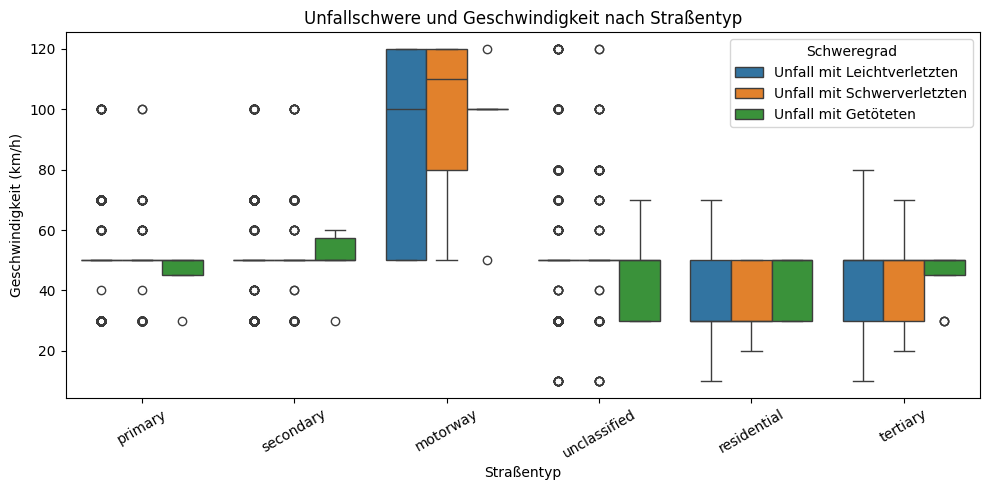

In [5]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='plot_color', y='maxspeed_clean', hue='UKATEGORIE', data=unfaelle)
plt.title("Unfallschwere und Geschwindigkeit nach Straßentyp")
plt.xlabel("Straßentyp")
plt.ylabel("Geschwindigkeit (km/h)")
plt.legend(title="Schweregrad")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

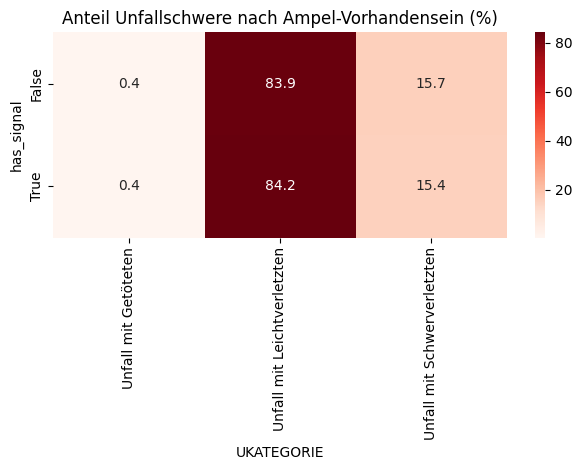

In [6]:
sns.heatmap(
    pd.crosstab(unfaelle['has_signal'], unfaelle['UKATEGORIE'], normalize='index') * 100,
    annot=True, cmap='Reds', fmt=".1f"
)
plt.title("Unfallschwere mit und ohne Ampel (%)")
plt.tight_layout()
plt.show()

### Baseline: LightGBM ohne Balancing
- Zeigt das Problem: Modell ignoriert die schweren Unfälle fast komplett
- Nur ~15% der Unfälle sind schwer, das Modell lernt einfach immer "leicht" vorherzusagen

In [8]:
unfaelle['is_severe'] = unfaelle['UKATEGORIE'].apply(lambda x: 1 if "Schwer" in x else 0)
y = unfaelle['is_severe']

print(f"Klassenverteilung: {y.value_counts().to_dict()}")  # zeigt das Ungleichgewicht

features_baseline = [
    'USTUNDE', 'dist_school', 'dist_bar', 'dist_fuel', 'dist_center',
    'maxspeed_clean', 'lanes_clean', 'has_signal', 'has_crossing',
    'has_sidewalk', 'has_parking', 'plot_color',
    'UGEMEINDE', 'UJAHR', 'UMONAT', 'UWOCHENTAG', 'UART', 'UTYP1',
    'ULICHTVERH', 'IstRad', 'IstPKW', 'IstFuss', 'IstKrad',
    'IstGkfz', 'IstSonstige', 'LINREFX', 'LINREFY',
    'Jahreszeit', 'IstWochenende', 'StrassenZustand', 'StrassenZustand_Kat'
]

X_bl = pd.get_dummies(unfaelle[features_baseline], drop_first=True)
X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(X_bl, y, test_size=0.2, random_state=42, stratify=y)

model_bl = lgb.LGBMClassifier(random_state=42, verbose=-1)
model_bl.fit(X_train_bl, y_train_bl)

y_pred_bl = model_bl.predict(X_test_bl)
print("\nBaseline (ohne Balancing):")
print(classification_report(y_test_bl, y_pred_bl))

Klassenverteilung: {0: 12798, 1: 2362}

Baseline (ohne Balancing):
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2560
           1       0.60      0.10      0.16       472

    accuracy                           0.85      3032
   macro avg       0.73      0.54      0.54      3032
weighted avg       0.82      0.85      0.80      3032



### Hauptmodell: LightGBM mit class_weight
- Mehr Features, bereinigte Features (IDs und Koordinaten raus)
- classweight bestraft Fehler bei schweren Unfällen stärker
- GridSearchCV sucht die besten Hyperparameter

In [9]:
# Features: alles außer Zielvariable, IDs und Koordinaten
X = pd.get_dummies(
    unfaelle.drop(columns=[
        'UKATEGORIE', 'is_severe', 'OBJECTID', 'UIDENTSTLAE',
        'ULAND', 'UREGBEZ', 'UKREIS', 'UGEMEINDE', 'UJAHR',
        'LINREFX', 'LINREFY', 'XGCSWGS84', 'YGCSWGS84', "name",
        "ref", "bridge", "tunnel", "access", "junction",
        "plot_color", "reversed", "osmid", "lanes", "maxspeed",
        "u", "v", "key", "length", "dist_m"
    ]),
    drop_first=True
)

# Spaltennamen bereinigen für LightGBM
X = X.loc[:, ~X.columns.duplicated()]
X.columns = (
    X.columns
    .str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    .str.replace('__+', '_', regex=True)
    .str.strip('_')
)
X = X.loc[:, ~X.columns.duplicated()]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

print(f"Features: {X.shape[1]}, Train: {len(X_train)}, Test: {len(X_test)}")

Features: 162, Train: 12128, Test: 3032


In [10]:
param_grid = {
    "n_estimators": [300, 500, 800],
    "learning_rate": [0.03, 0.05, 0.1],
    "num_leaves": [31, 63],
    "min_child_samples": [20, 40],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(
    lgb.LGBMClassifier(random_state=42, verbose=-1, class_weight={0: 0.59, 1: 3.21}),
    param_grid,
    scoring="f1",  # optimiert auf F1 für die positive Klasse (schwer)
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

search.fit(X_train, y_train)

model = search.best_estimator_
print(f"\nBester CV F1: {search.best_score_:.3f}")
print("Parameter:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Bester CV F1: 0.423
Parameter:
  learning_rate: 0.03
  min_child_samples: 20
  n_estimators: 500
  num_leaves: 63


### Evaluation
- Threshold-Optimierung: Standard ist 0.5, aber bei unbalancierten Klassen oft nicht optimal
- Bester Threshold wird über F1-Score der Precision-Recall-Kurve bestimmt

In [11]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Bewertung (Standard Threshold 0.5):")
print(classification_report(y_test, y_pred))
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

# Optimalen Threshold finden über PR-Kurve
prec, rec, th = precision_recall_curve(y_test, y_proba)
f1 = np.where((prec + rec) > 0, 2 * (prec * rec) / (prec + rec), 0)  # Division durch 0 vermeiden
best_threshold = th[np.argmax(f1)]
print(f"\nOptimaler Threshold: {best_threshold:.3f}")

y_pred_opt = (y_proba > best_threshold).astype(int)

print("\nBewertung (optimaler Threshold):")
print(classification_report(y_test, y_pred_opt))
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_opt):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"F1 (Schwer): {f1_score(y_test, y_pred_opt, pos_label=1):.3f}")

Bewertung (Standard Threshold 0.5):
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2560
           1       0.43      0.47      0.45       472

    accuracy                           0.82      3032
   macro avg       0.67      0.68      0.67      3032
weighted avg       0.83      0.82      0.82      3032

Balanced Accuracy: 0.677
ROC-AUC: 0.768

Optimaler Threshold: 0.529

Bewertung (optimaler Threshold):
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2560
           1       0.48      0.45      0.46       472

    accuracy                           0.84      3032
   macro avg       0.69      0.68      0.68      3032
weighted avg       0.83      0.84      0.84      3032

Balanced Accuracy: 0.679
ROC-AUC: 0.768
F1 (Schwer): 0.463


### Visualisierung

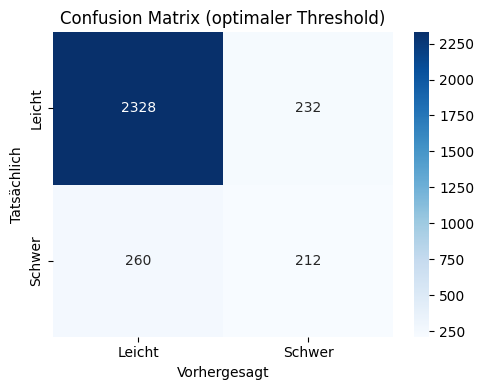

In [12]:
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Leicht", "Schwer"], yticklabels=["Leicht", "Schwer"])
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title("Confusion Matrix (optimaler Threshold)")
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

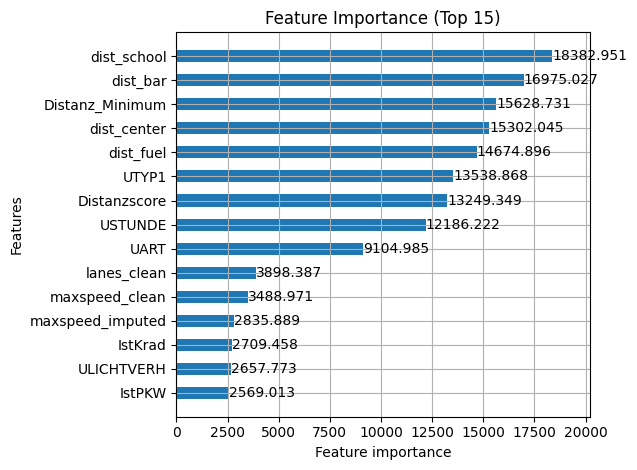

In [13]:
plt.figure(figsize=(8, 6))
lgb.plot_importance(model, max_num_features=15, importance_type='gain', height=0.5)
plt.title("Feature Importance (Top 15)")
plt.tight_layout()
plt.show()

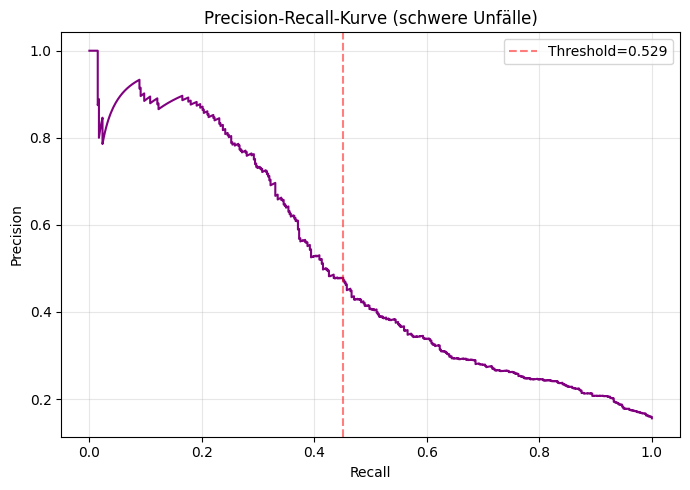

In [14]:
plt.figure(figsize=(7, 5))
plt.plot(rec, prec, color='purple')
plt.axvline(x=rec[np.argmax(f1)], color='red', linestyle='--', alpha=0.5, label=f'Threshold={best_threshold:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall-Kurve (schwere Unfälle)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Das Modell erkennt schwere Unfälle besser als die Baseline, aber Precision und Recall bleiben niedrig. Unfallschwere hängt stark von Faktoren ab die nicht in den Daten stehen (Geschwindigkeit zum Unfallzeitpunkt, Alkohol, Wetter etc.).

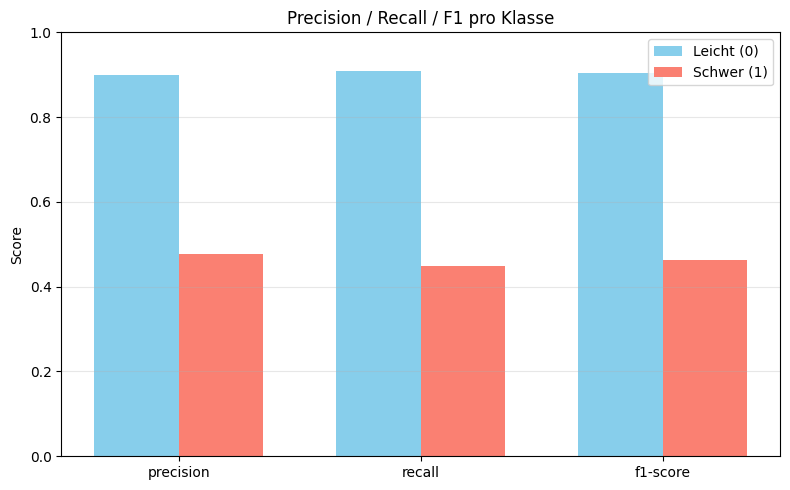

In [15]:
report = classification_report(y_test, y_pred_opt, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
values = [[report['0'][m], report['1'][m]] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, [v[0] for v in values], width, label='Leicht (0)', color='skyblue')
plt.bar(x + width/2, [v[1] for v in values], width, label='Schwer (1)', color='salmon')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Precision / Recall / F1 pro Klasse')
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()